In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
#读取图片
from PIL import Image
import os
import numpy as np
X=[]
y=[]
db='-10'
for file in os.listdir('new_allsort_stftdefault/'+db):#new_bb_qf_stftdefault except_psk_stftdefault new_allsort_stftdefault
        # 660_new_bb_qf_stftdefault
    #if 'spwvd' in file:
        img = Image.open('new_allsort_stftdefault/'+db+'/'+file)  #三通道
        #img = Image.open('psk/'+file).convert('L') #单通道
        #img.resize((128, 128)).show()
        img = np.asarray(img.resize((64, 64)))   # 改变图片尺寸
        X.append(img/255)
        y.append(file.split('_')[0])
    #else:
        #pass
X=np.array(X)
np.savez('CWRU_12k_load_1hp_rawdata_64-64', data = X, labels = y)

In [4]:
#信号分类模型
import tensorflow as tf
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import random
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#tf.set_random_seed(seed)#固定模型参数

file = np.load("CWRU_12k_load_1hp_rawdata_64-64.npz")
file.files

raw_data = file["data"]
labels = file["labels"]
raw_data.shape

#print(raw_data)
data = raw_data
print(data.shape)
#print(data)

(3500, 64, 64, 3)


In [5]:
labels

array(['bfsk', 'bfsk', 'bfsk', ..., 'qpskFrank', 'qpskFrank', 'qpskFrank'],
      dtype='<U12')

In [6]:
maps={}
flag=0
for i in set(labels):
    maps[i]=flag
    flag+=1
print(maps)
labels=pd.Series(labels).map(maps) #将名称变量转化为数字label

{'qpskFrank': 0, 'qfsk': 1, 'cw': 2, 'bfsk': 3, 'NLFM': 4, 'LFM': 5, 'newbpskBAKER': 6}


In [7]:
labels=np.array(labels).flatten()

In [8]:


# 标签类型

category_labels = np.unique(labels)
labels = pd.Categorical(labels, categories = category_labels).codes
print(category_labels)
#划分训练集和测试集
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size = 0.6, random_state = 1, stratify = labels,shuffle=True)

# reshape 
#train_data = train_data.reshape(len(train_data),64,64,3)
#test_data = test_data.reshape(len(test_data),64,64,3)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Shuffle data
#index = np.random.permutation(len(train_labels))
#train_data, train_labels = train_data[index], train_labels[index]

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

[0 1 2 3 4 5 6]
(1400, 64, 64, 3) (1400, 7) (2100, 64, 64, 3) (2100, 7)


In [9]:
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
import tensorflow as tf
import numpy as np

In [10]:
# 创建模型序列
model = Sequential()
#第一层卷积网络，使用96个卷积核，大小为11x11步长为1， 要求输入的图片为64x64， 3个通道，加边，激活函数使用relu
model.add(Conv2D(96, (11,11), strides=(1, 1), input_shape=(64, 64, 3), padding='same', activation='relu',
                 kernel_initializer='uniform'))
#model.add(Dropout(0.2))#默认0.2
# 池化层
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# 第二层加边使用256个5x5的卷积核，加边，激活函数为relu
model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
#使用池化层，步长为2
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# 第三层卷积，大小为3x3的卷积核使用384个
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
# 第四层卷积,同第三层
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
# 第五层卷积使用的卷积核为256个，其他同上
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(1e-4), metrics=['accuracy'])#正常3e-5
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 384)       1

In [11]:
from keras.callbacks import ModelCheckpoint
cp= ModelCheckpoint(filepath="cnn_model.h5",
                               save_best_only=True,
                               verbose=1)  #保存模型
'''model.compile(loss = 'categorical_crossentropy', 
                  optimizer = tensorflow.keras.optimizers.Adam(1e-5), 
                  metrics= ['accuracy'])'''


# 训练
history = model.fit(train_data, train_labels, epochs = 35, batch_size = 64, 
                    validation_data=(test_data, test_labels))#verbose = 1,callbacks=[cp]保存模型

# 预测
res = model.evaluate(test_data, test_labels, batch_size = 64, verbose = 1)[1]
print("=" * 100)
print('evaluate finish, Accuracy: %4.4f' % (res * 100))




Epoch 1/35
22/22 [==============================] - 128s 6s/step - loss: 2.0855 - accuracy: 0.1414 - val_loss: 1.9439 - val_accuracy: 0.1429
Epoch 2/35
22/22 [==============================] - 128s 6s/step - loss: 1.9526 - accuracy: 0.1486 - val_loss: 1.9416 - val_accuracy: 0.2310
Epoch 3/35
22/22 [==============================] - 131s 6s/step - loss: 1.9446 - accuracy: 0.1529 - val_loss: 1.9322 - val_accuracy: 0.1595
Epoch 4/35
22/22 [==============================] - 129s 6s/step - loss: 1.8966 - accuracy: 0.2457 - val_loss: 1.7305 - val_accuracy: 0.4105
Epoch 5/35
22/22 [==============================] - 127s 6s/step - loss: 1.2980 - accuracy: 0.4600 - val_loss: 0.8424 - val_accuracy: 0.5810
Epoch 6/35
22/22 [==============================] - 127s 6s/step - loss: 0.8569 - accuracy: 0.5757 - val_loss: 0.7312 - val_accuracy: 0.6019
Epoch 7/35
22/22 [==============================] - 126s 6s/step - loss: 0.7401 - accuracy: 0.6379 - val_loss: 0.6759 - val_accuracy: 0.6629
Epoch 8/35
22

In [50]:
pred_label=model.predict(test_data)

23/23 [==============================] - 8s 353ms/step


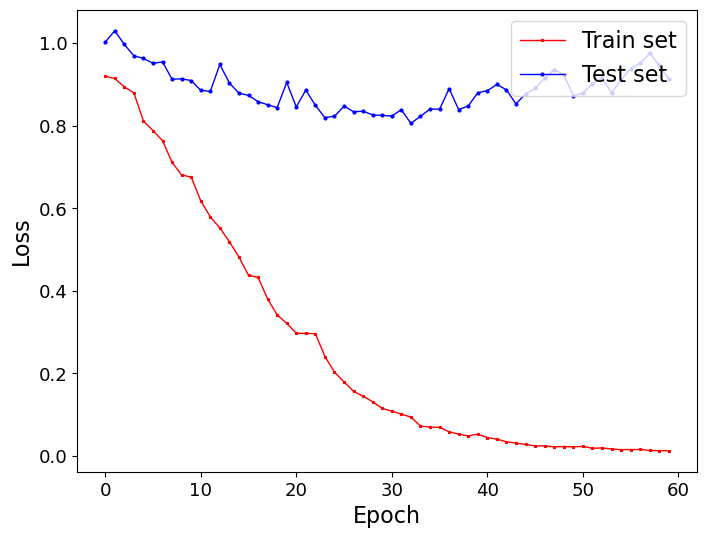

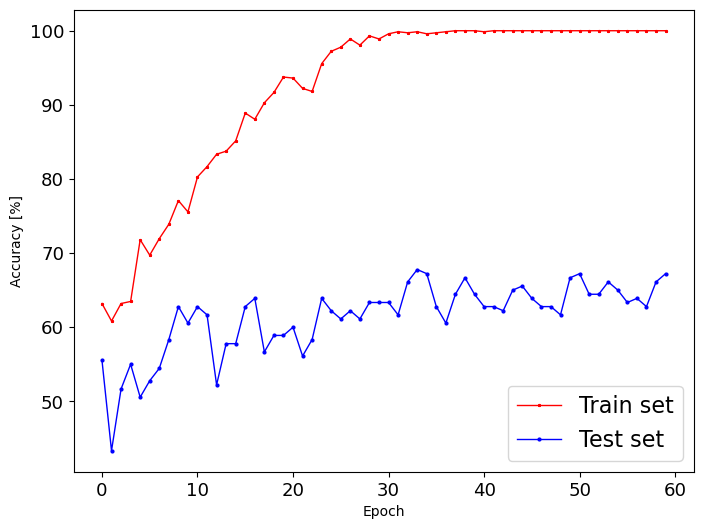

In [16]:
# 绘制训练&测试集的损失曲线
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], 'r-*', linewidth=1, markersize=2)
plt.plot(history.history['val_loss'], 'b-o', linewidth=1, markersize=2)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train set', 'Test set'], fontsize=16, loc='upper right')
plt.show()

# 绘制训练&测试集的准确率曲线
plt.figure(figsize=(8, 6))
plt.plot(np.array(history.history['accuracy']) * 100, 'r-*', linewidth=1, markersize=2)
plt.plot(np.array(history.history['val_accuracy']) * 100, 'b-o', linewidth=1, markersize=2)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Test set'], fontsize=16, loc='lower right')
plt.show()

In [18]:
from keras.models import load_model
model= load_model('cnn_model.h5') #加载模型

In [12]:
pre_labels=model.predict(test_data)
pre_labels = np.argmax(pre_labels, axis=1)
from sklearn.metrics import accuracy_score
accuracy_score(pre_labels,np.argmax(test_labels,axis=1))

66/66 [==============================] - 32s 478ms/step


0.8419047619047619

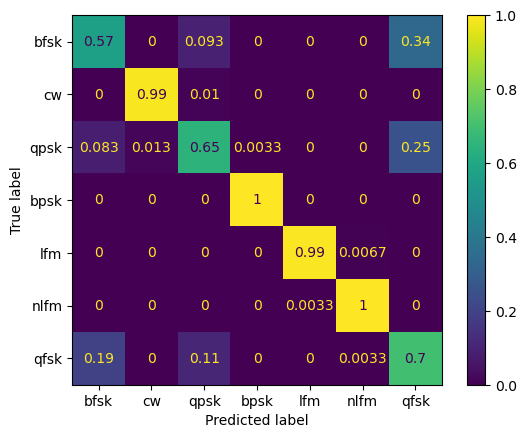

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 得到混淆矩阵(confusion matrix,简称cm)
# confusion_matrix 需要的参数：y_true(真实标签),y_pred(预测标签),normalize(归一化,'true', 'pred', 'all')
cm = confusion_matrix(y_true=np.argmax(test_labels,axis=1), y_pred=pre_labels, normalize='true')
#{'bpsk': 0, 'lfm': 1, 'nlfm': 2, 'qfsk': 3, 'lfm3M': 4, 'qpsk': 5, 'bfsk': 6}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bfsk','cw','qpsk','bpsk','lfm','nlfm','qfsk'])
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cw','qpsk','bpsk'])
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['b','l','n','c','q'])
disp.plot()
#plt.savefig("cm.jpg")

In [13]:
cm

array([[0.98333333, 0.01333333, 0.        , 0.        , 0.        ,
        0.00333333, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.71      , 0.13333333, 0.15666667,
        0.        , 0.        ],
       [0.        , 0.        , 0.37333333, 0.43333333, 0.19333333,
        0.        , 0.        ],
       [0.        , 0.02      , 0.18333333, 0.07      , 0.72666667,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.99666667, 0.00333333],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01333333, 0.98666667]])

In [ ]:
model.summary()

In [41]:
import tensorflow.keras.backend as K
output_layer = 'conv2d_10' 
output = model.get_layer(output_layer).output
functors = K.function([model.input], [output])
D_pred=functors(test_data)[0]
D_pred.shape

(129, 128, 128, 96)

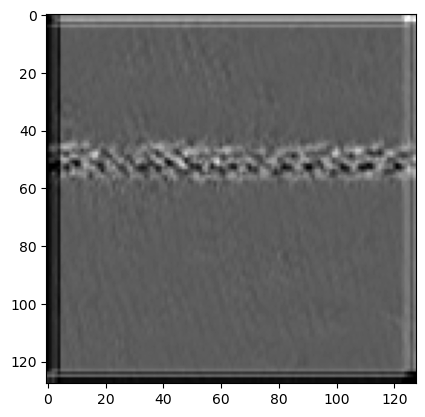

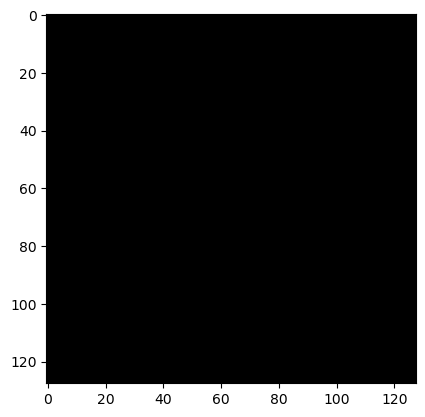

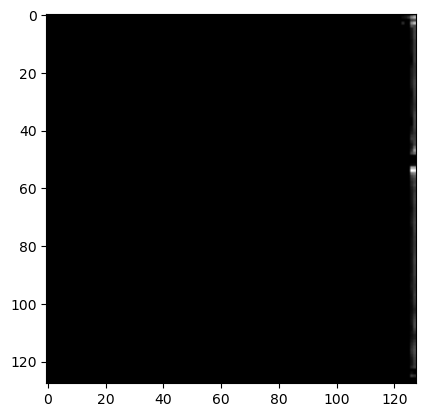

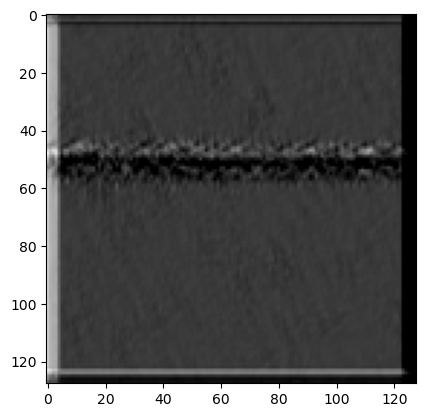

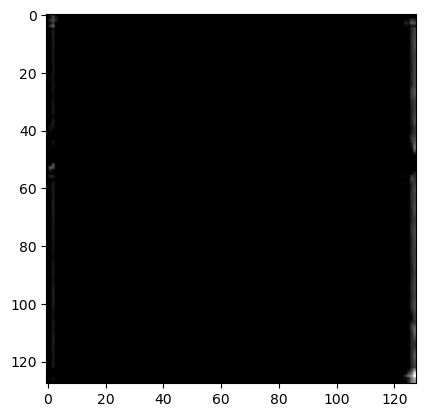

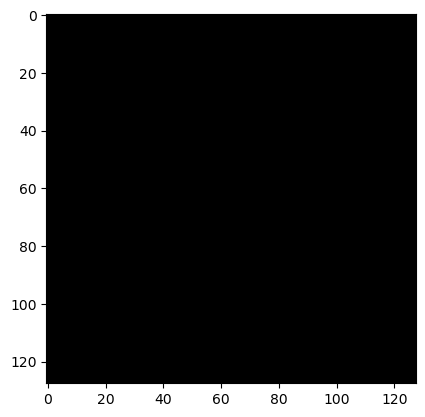

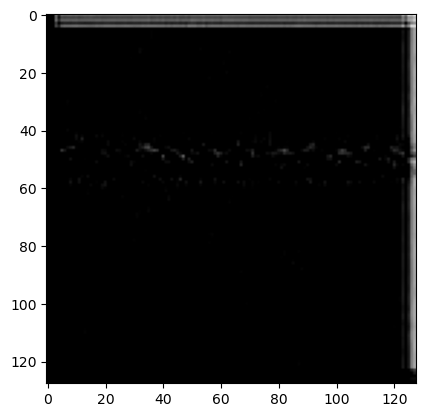

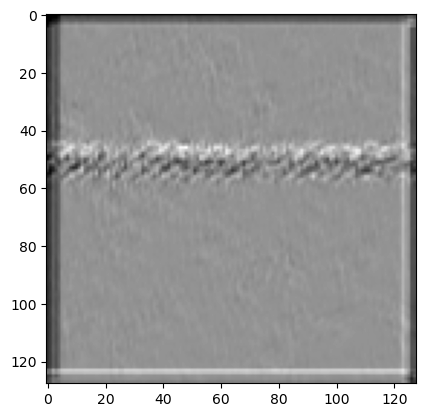

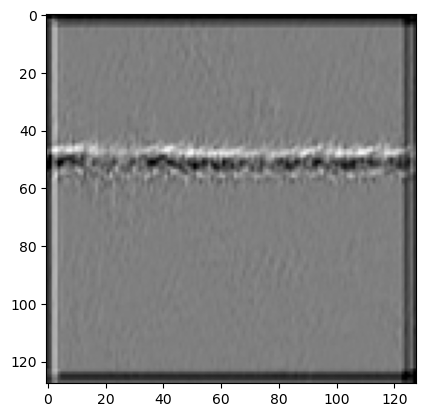

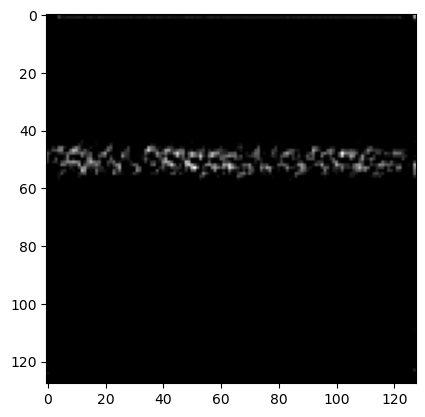

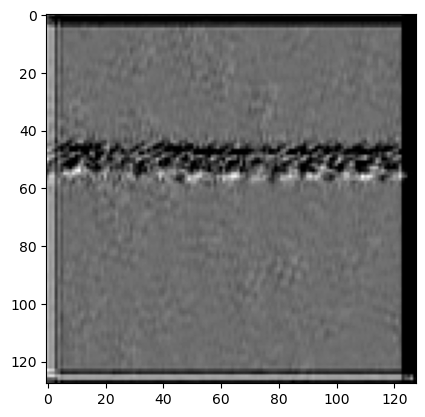

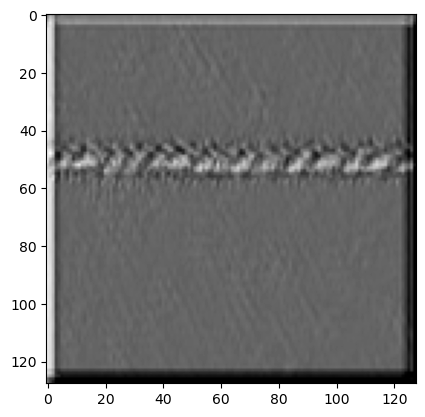

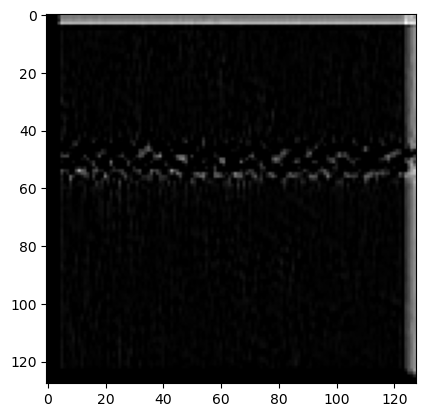

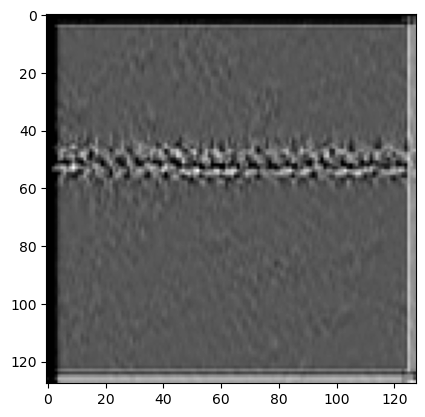

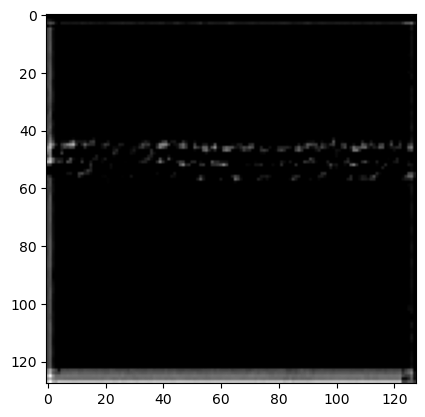

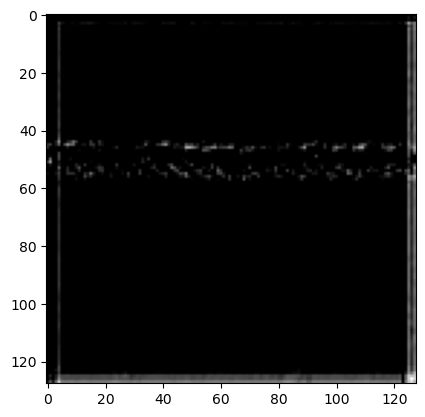

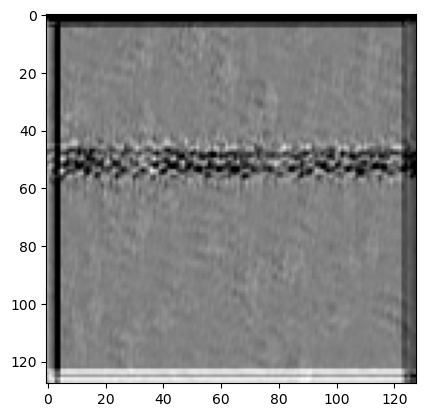

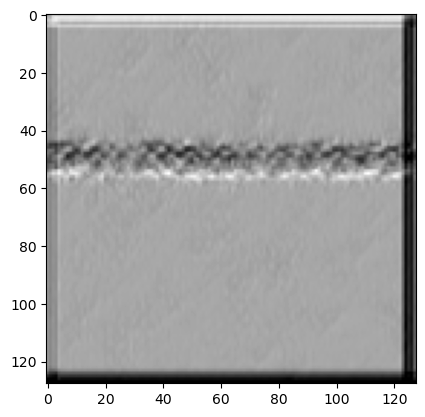

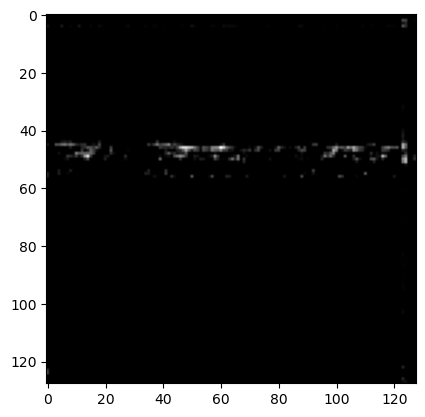

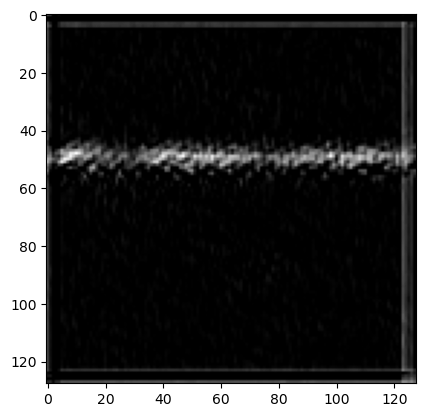

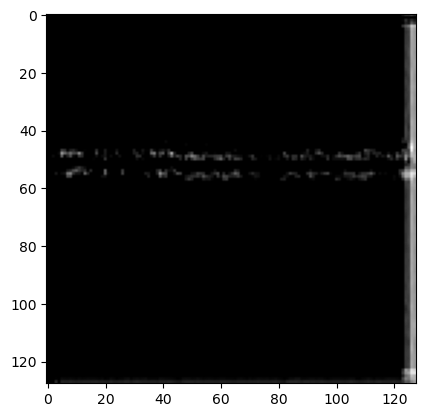

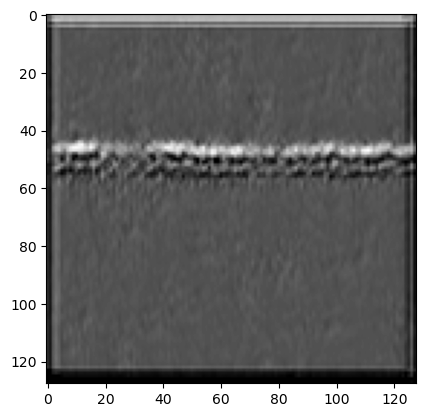

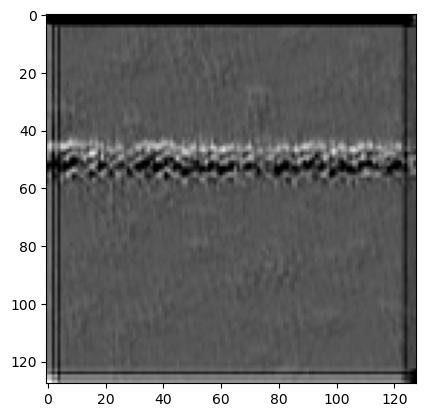

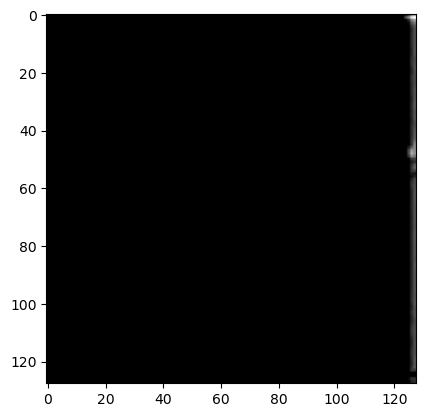

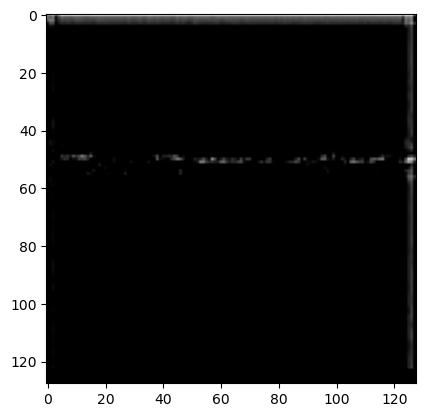

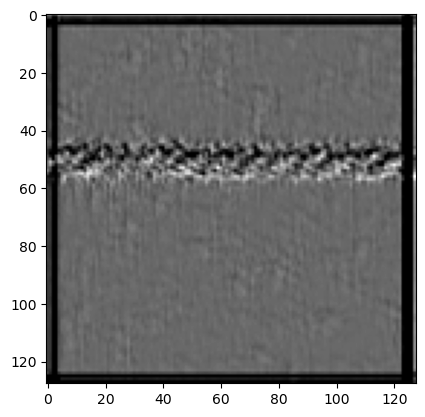

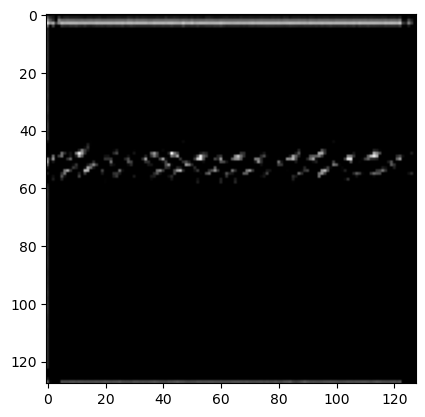

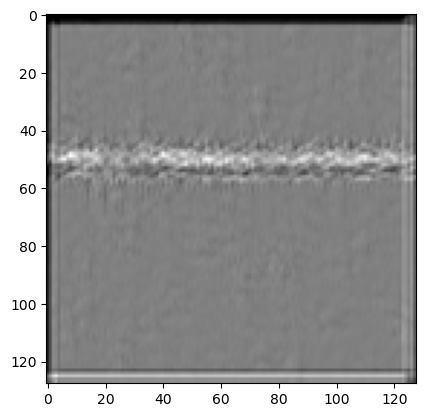

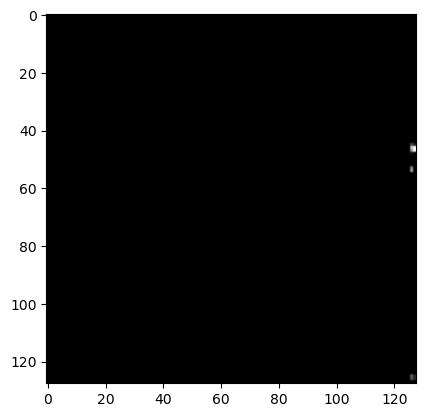

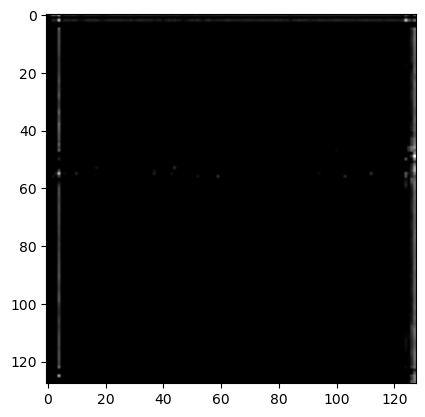

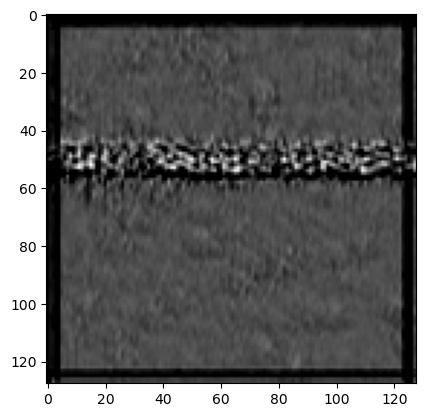

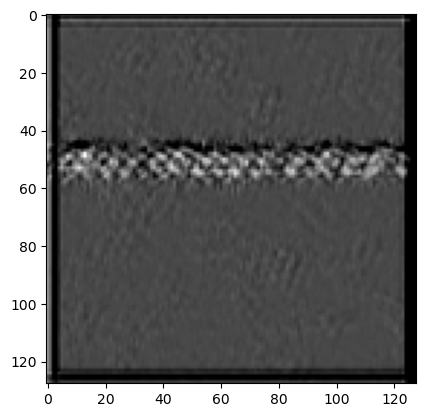

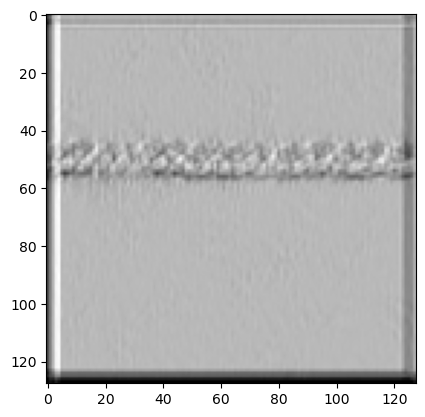

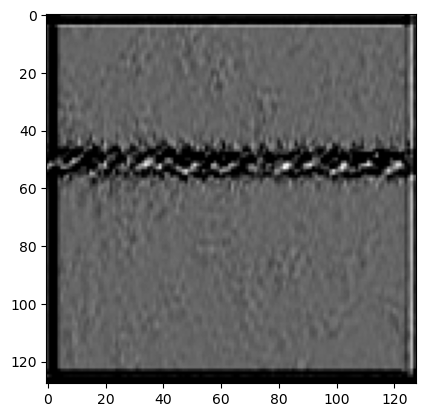

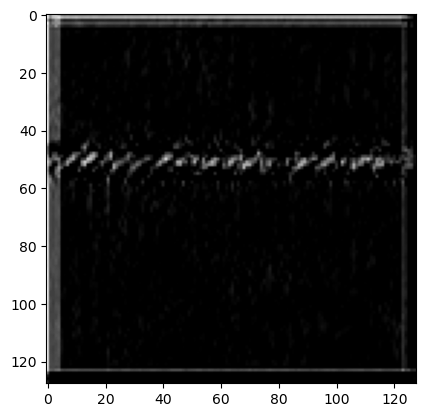

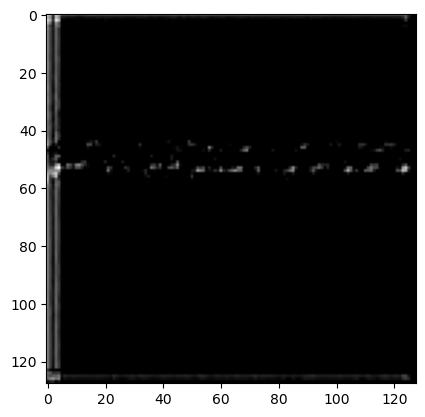

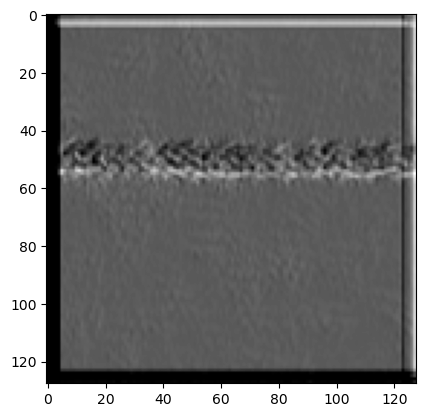

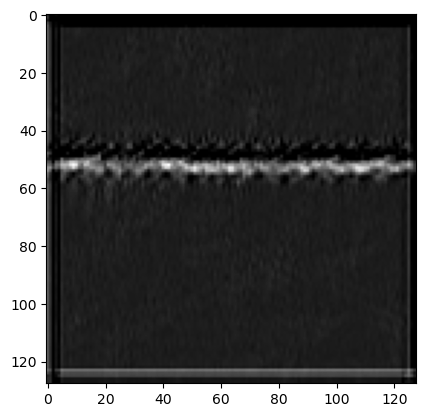

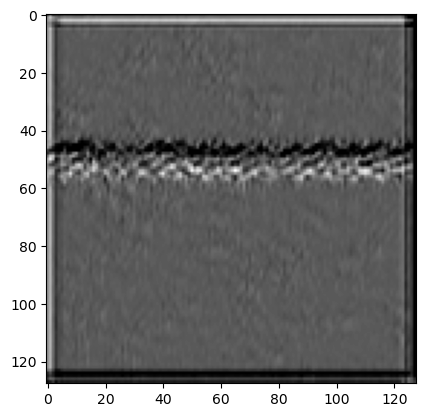

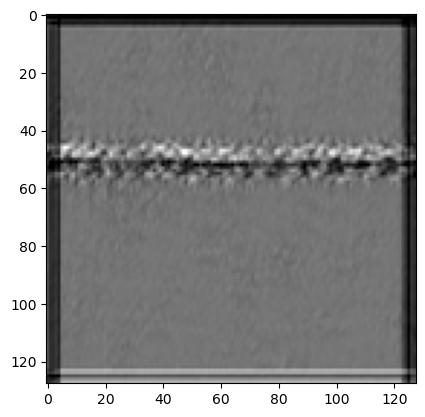

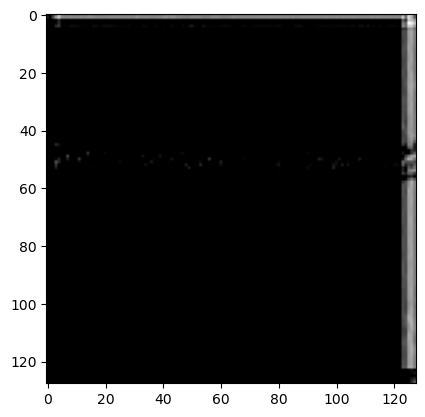

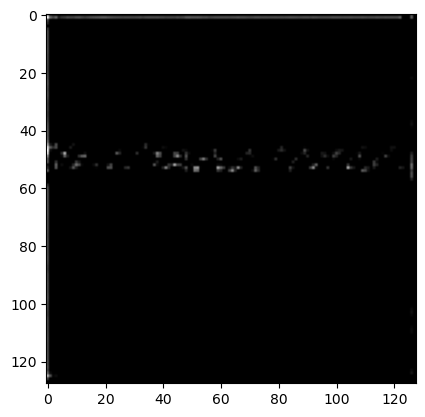

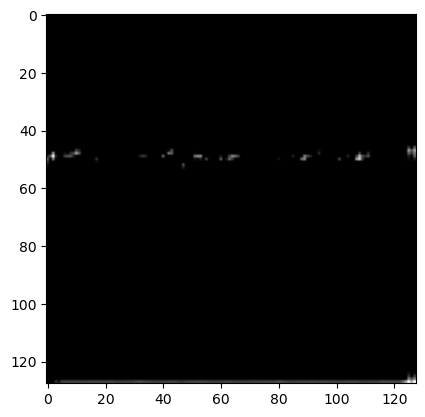

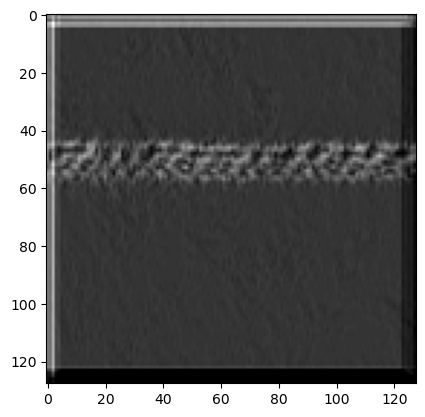

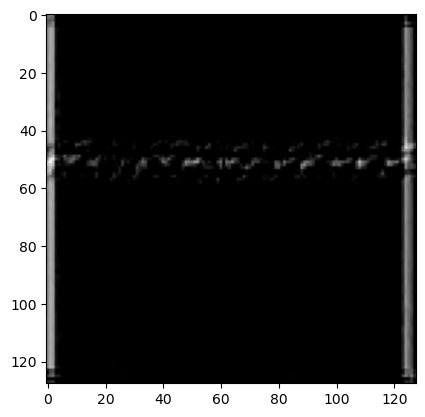

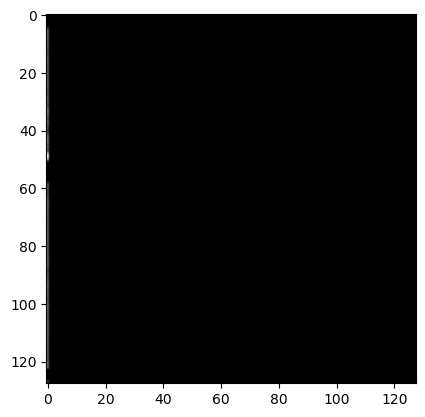

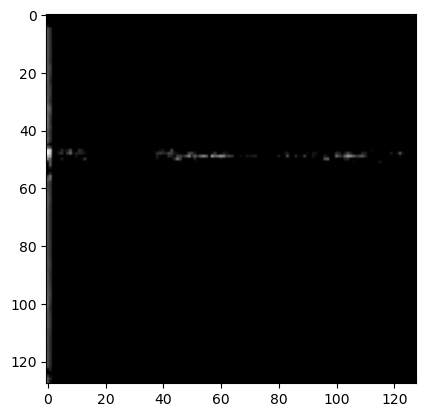

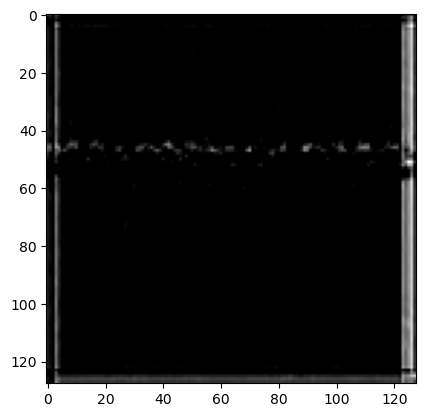

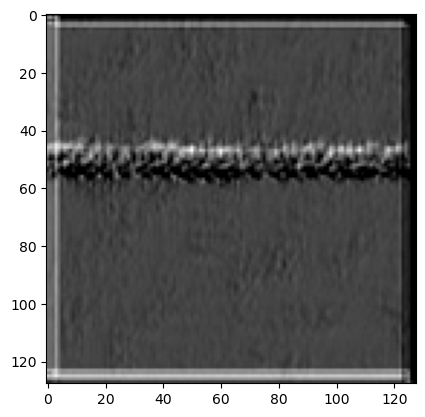

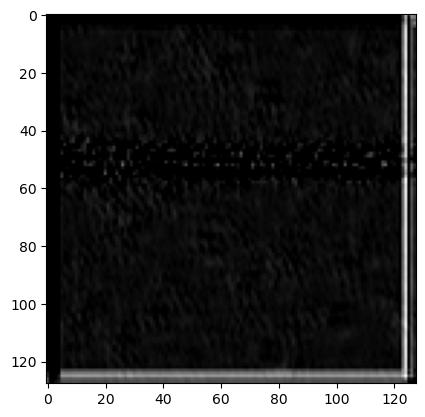

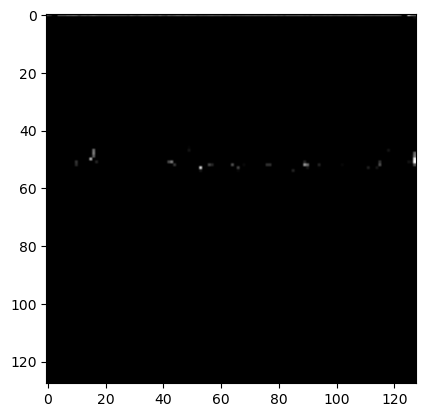

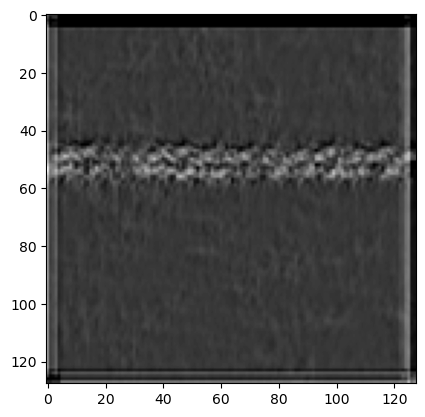

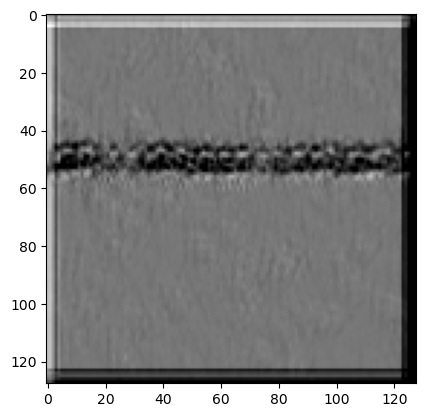

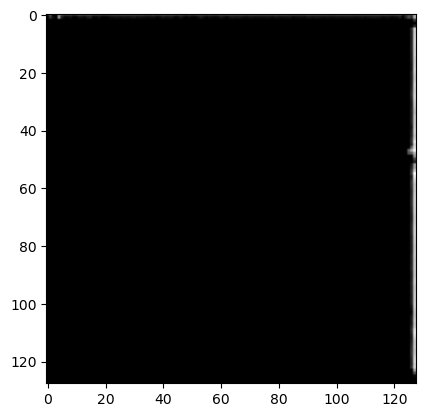

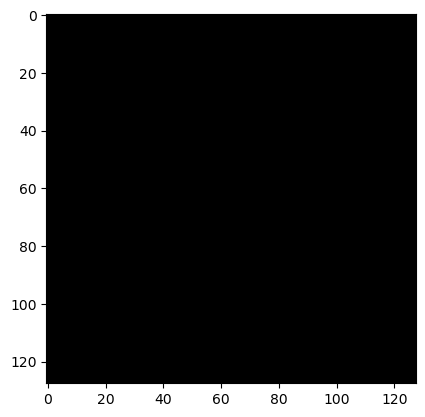

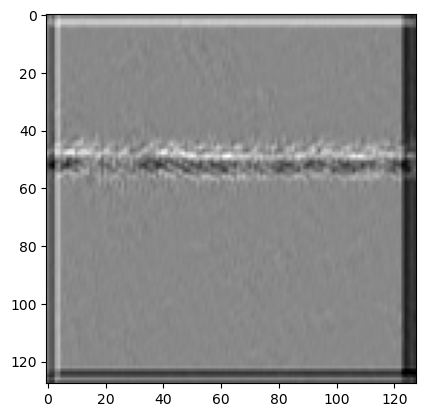

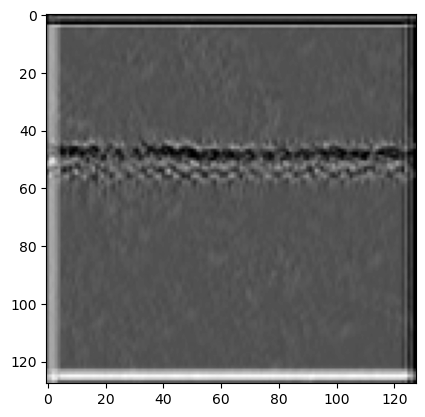

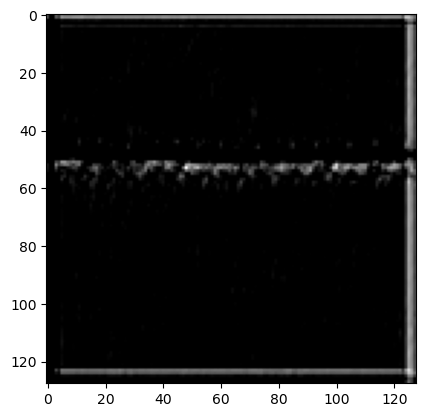

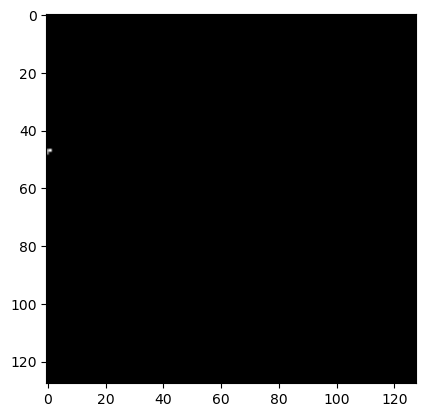

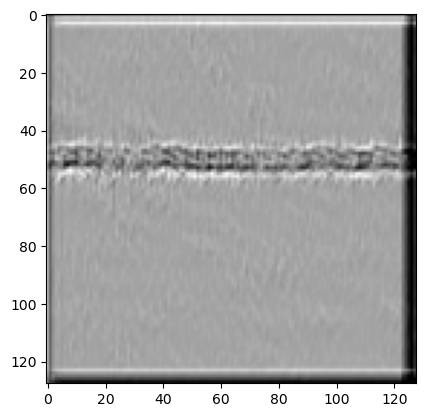

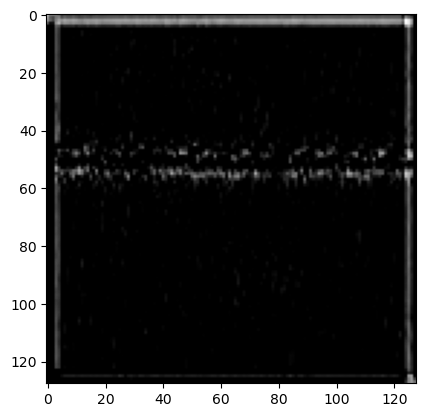

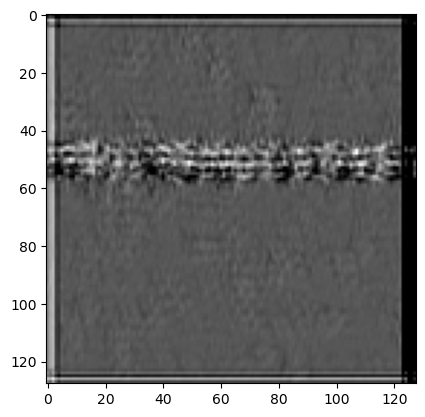

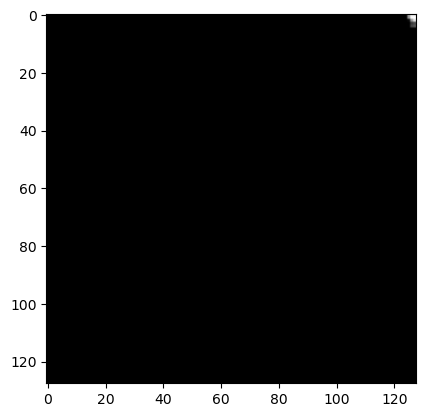

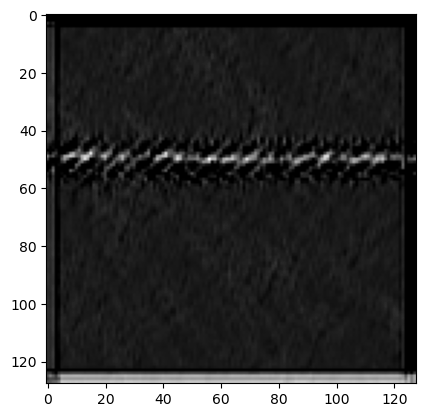

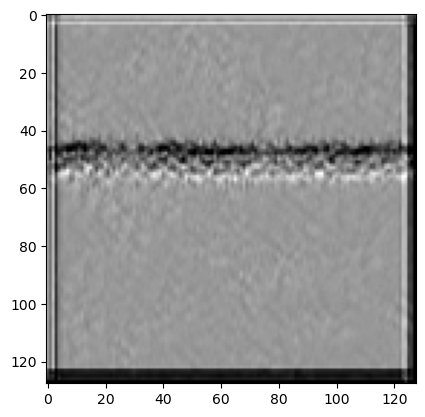

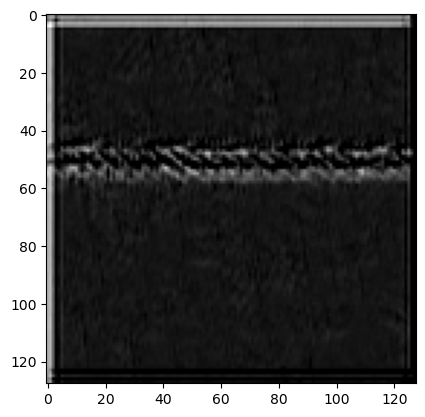

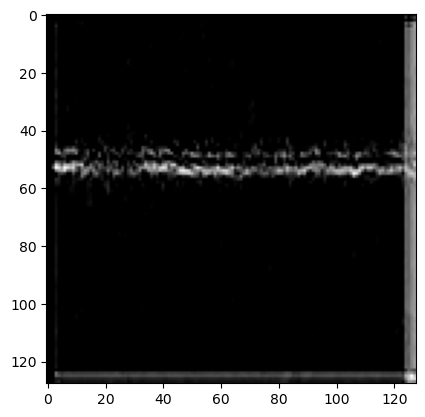

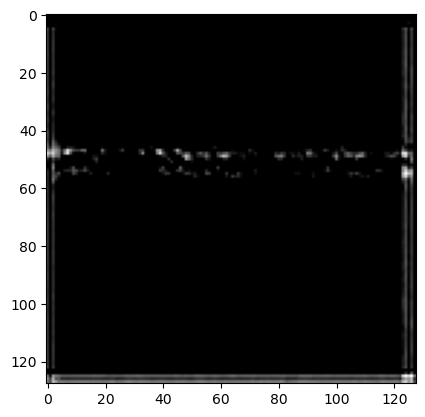

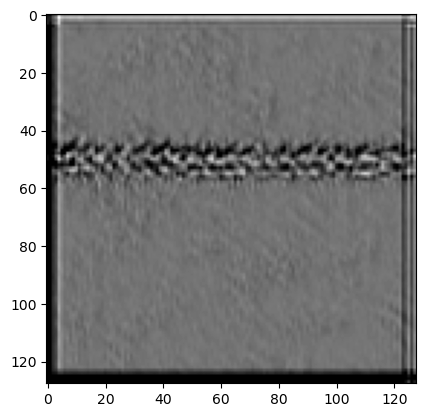

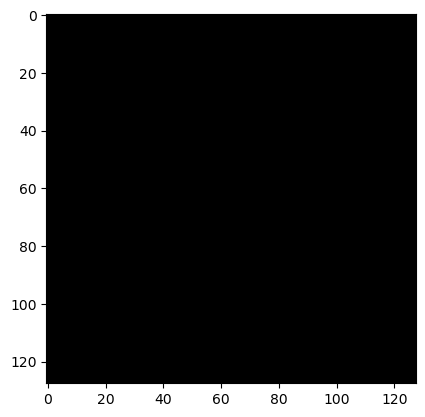

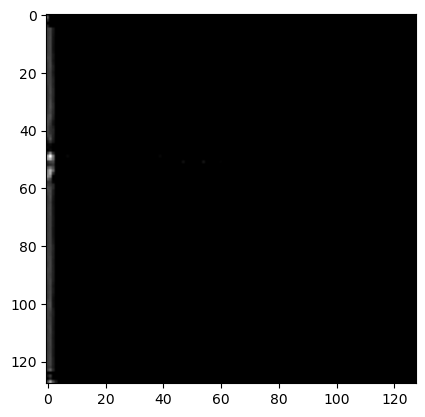

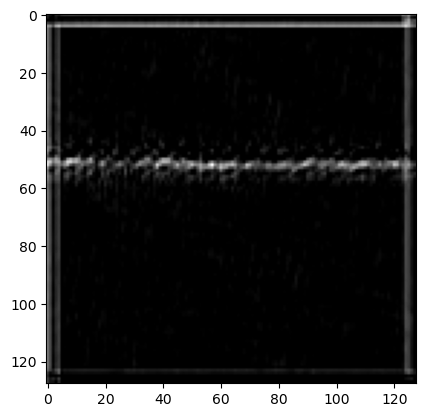

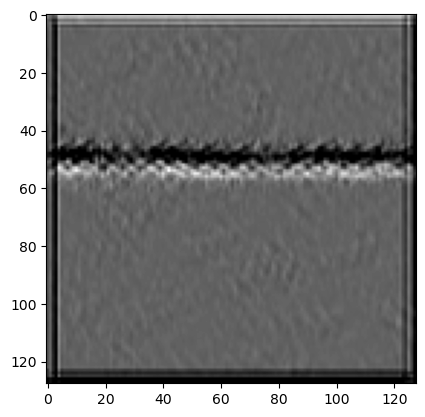

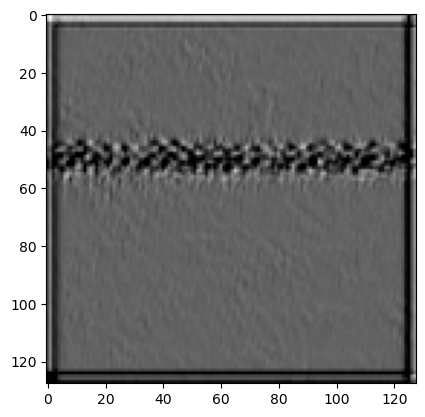

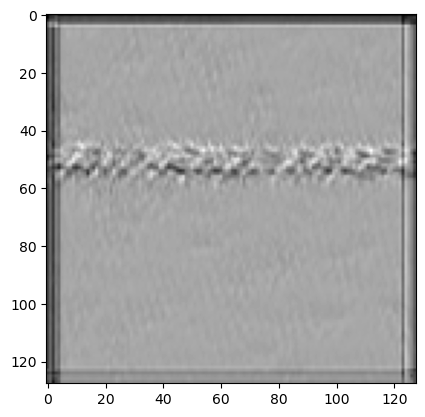

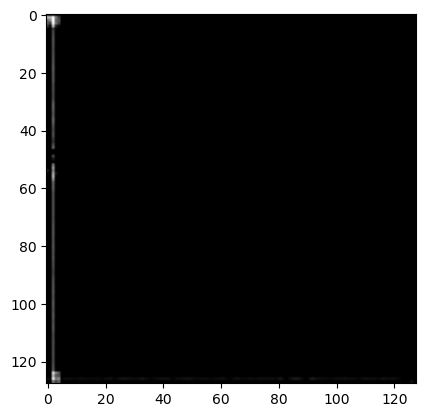

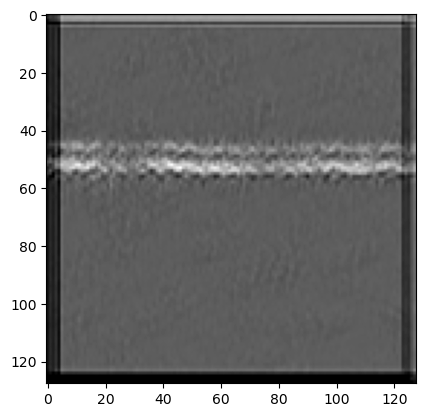

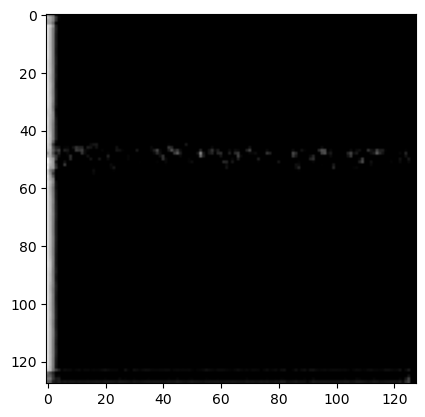

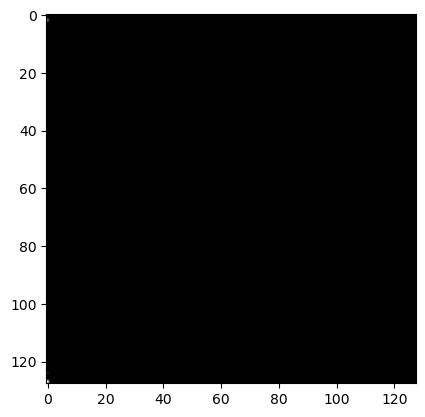

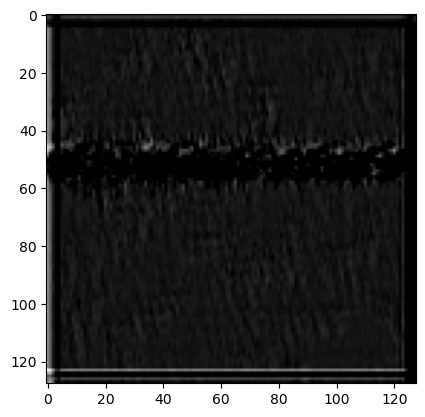

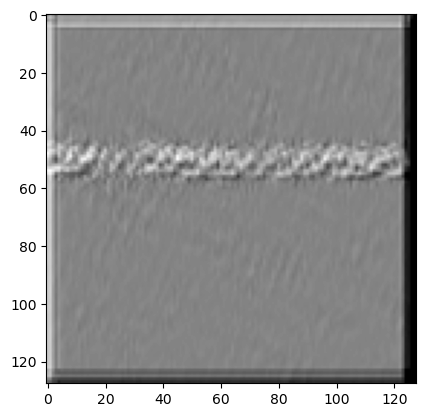

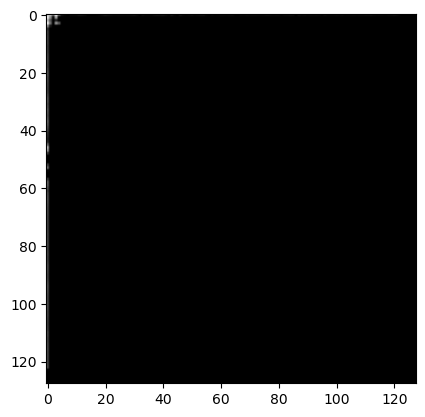

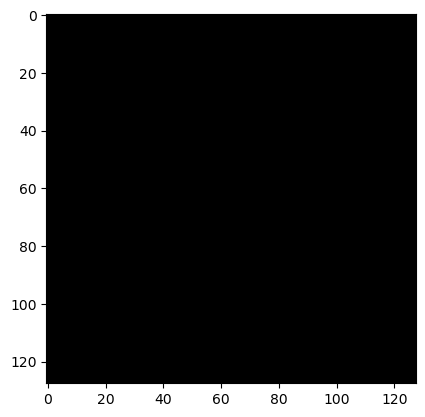

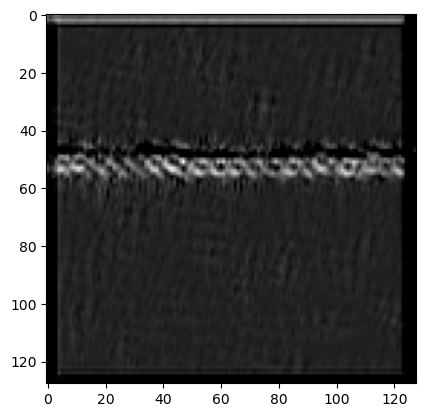

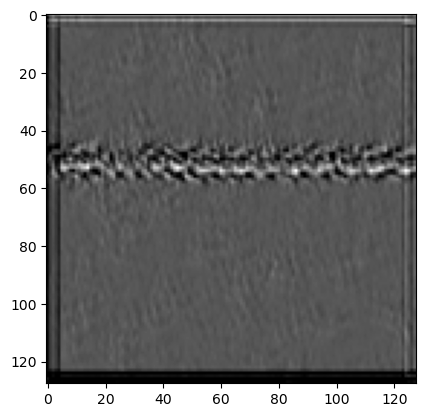

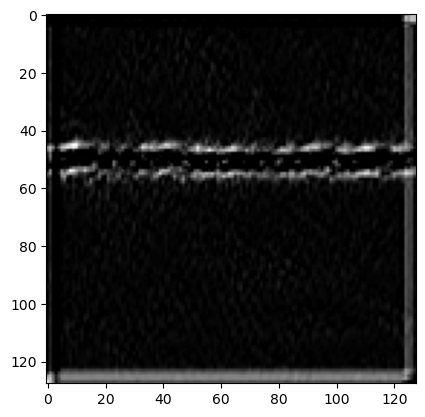

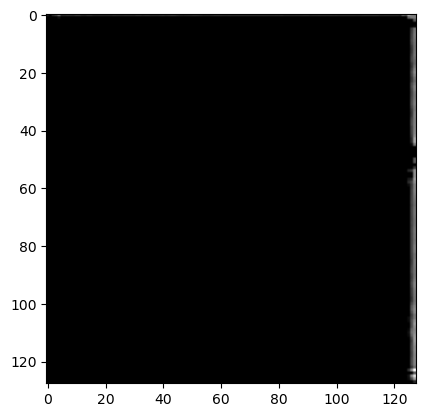

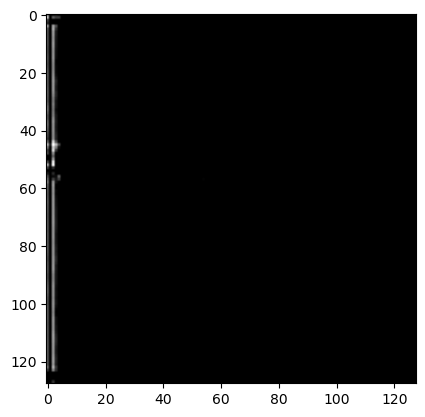

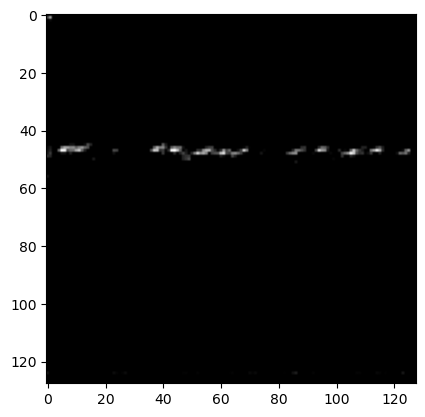

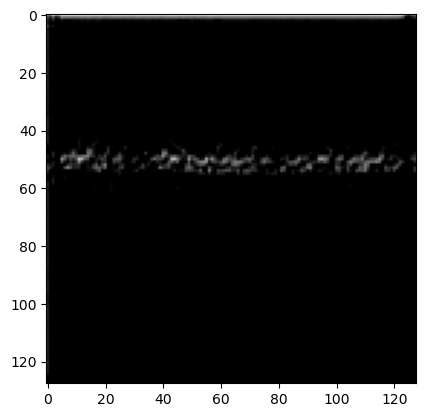

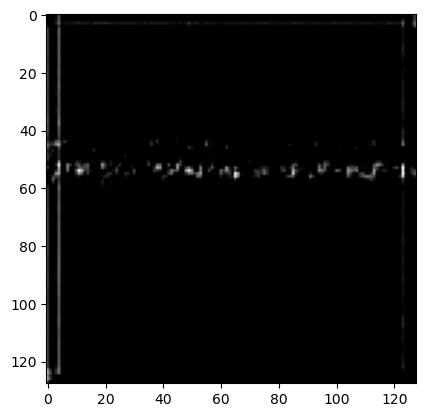

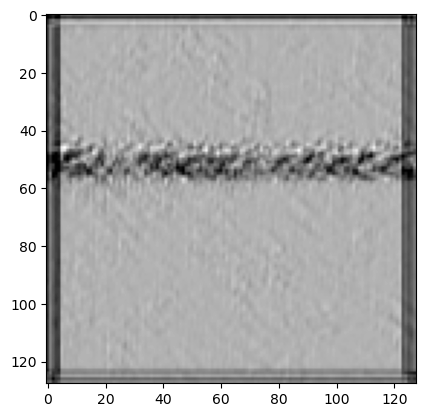

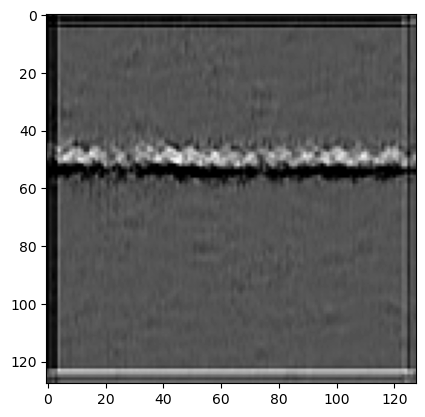

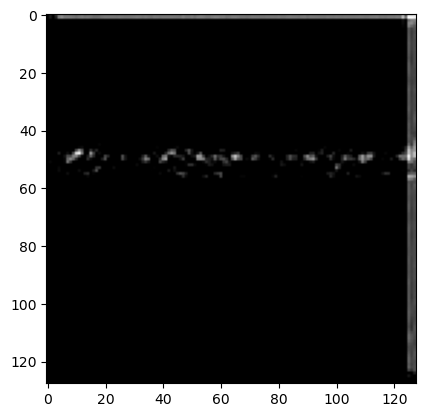

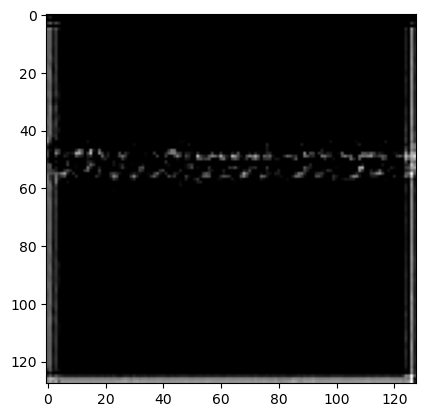

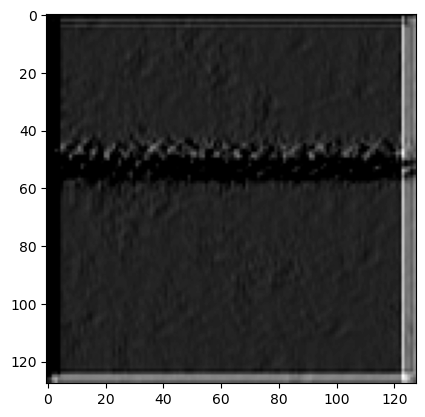

TypeError: Invalid shape (128, 128, 0) for image data

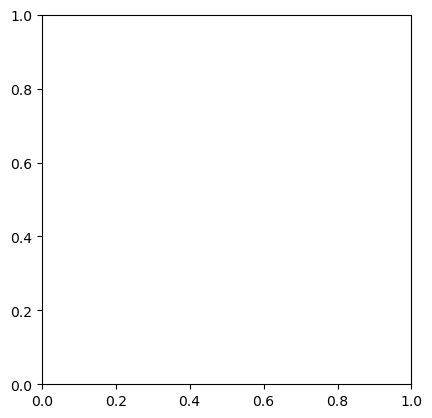

In [42]:
for i in range(256):
    pic=D_pred[0,:,:,i:i+1]
    plt.imshow(pic, cmap='gray')
    plt.show()